In [1]:
import pandas as pd
import numpy as np
import pymc

%matplotlib inline
import os
import math
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image, HTML
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime


In [94]:
df_16=pd.read_csv("C:\\Users\\Yannick\\Documents\\CoursENSAE\\Statapp\\F1_1617.csv")
df_15=pd.read_csv("C:\\Users\\Yannick\\Documents\\CoursENSAE\\Statapp\\F1_1516.csv")
df_14=pd.read_csv("C:\\Users\\Yannick\\Documents\\CoursENSAE\\Statapp\\F1_1415.csv")
df_13=pd.read_csv("C:\\Users\\Yannick\\Documents\\CoursENSAE\\Statapp\\F1_1314.csv")
df_12=pd.read_csv("C:\\Users\\Yannick\\Documents\\CoursENSAE\\Statapp\\F1_1213.csv")

df_15=df_15.drop(380)
df_13=df_13.drop(380)
df_15.head(10)


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,F1,07/08/15,Lille,Paris SG,0.0,1.0,A,0.0,0.0,D,...,1.63,25.0,0.75,2.11,2.03,1.85,1.80,7.58,3.91,1.58
1,F1,08/08/15,Bastia,Rennes,2.0,1.0,H,0.0,1.0,A,...,1.50,27.0,0.00,1.87,1.80,2.10,2.03,2.81,2.93,3.10
2,F1,08/08/15,Marseille,Caen,0.0,1.0,A,0.0,1.0,A,...,2.15,31.0,-1.00,2.00,1.92,1.95,1.90,1.57,4.13,7.04
3,F1,08/08/15,Montpellier,Angers,0.0,2.0,A,0.0,1.0,A,...,1.54,26.0,-0.50,1.84,1.78,2.13,2.06,1.84,3.42,5.42
4,F1,08/08/15,Nantes,Guingamp,1.0,0.0,H,0.0,0.0,D,...,1.44,25.0,-0.25,1.87,1.82,2.10,2.01,2.37,3.01,3.76
5,F1,08/08/15,Nice,Monaco,1.0,2.0,A,1.0,0.0,H,...,1.57,30.0,0.50,1.88,1.79,2.13,2.05,4.36,3.42,1.99
6,F1,08/08/15,Troyes,Ajaccio GFCO,0.0,0.0,D,0.0,0.0,D,...,1.56,25.0,-0.50,2.07,1.99,1.90,1.84,2.00,3.42,4.41
7,F1,09/08/15,Bordeaux,Reims,1.0,2.0,A,1.0,0.0,H,...,1.80,26.0,-0.75,1.92,1.86,2.03,1.96,1.72,3.80,5.70
8,F1,09/08/15,Lyon,Lorient,0.0,0.0,D,0.0,0.0,D,...,1.97,31.0,-1.00,2.04,1.95,1.93,1.87,1.55,4.24,7.20
9,F1,09/08/15,Toulouse,St Etienne,2.0,1.0,H,1.0,1.0,D,...,1.56,27.0,0.00,2.21,2.07,1.83,1.77,2.71,3.18,2.93


In [5]:
#df_tot=(pd.concat([df_12,df_13,df_14,df_15,df_16]))[["Date","HomeTeam","AwayTeam","FTHG","FTAG","FTR"]]



# On instancie notre tokenizer
def to_datetime(x):
    a=np.array(x.Date.split('/')).astype(int)
    return datetime(a[2],a[1],a[0])

df_15['Datetime']=df_15.apply(to_datetime,axis=1)

# dates=[datetime(12,6,1),datetime(13,12,1),datetime(14,6,1),datetime(15,8,1),
#        datetime(16,4,1),datetime(16,9,1),datetime(17,12,1)]
# coaches=["Baup",'Anigo','Bielsa','Michel','Passi','Garcia']

date_OL=datetime(15,12,31)

coaches=["Fournier","Genesio"]
df_Fournier=df_15[df_15.Datetime<date_OL]
df_Genesio=df_15[df_15.Datetime>date_OL]

# for i,c in enumerate(coaches):
#     print(c)
#     mask=df_tot.apply(lambda x: x.Datetime>dates[i],axis=1)
#     df_tot.loc[mask,'Coach_marseille']=c

In [83]:
def simulate(df_input):
    #year='14'
    df = df_input.rename(columns={'HomeTeam':'home','AwayTeam':'away','FTHG': 'home_score', 'FTAG': 'away_score'})
    df=df[['home','away','home_score', 'away_score']]

    teams = df.home.unique()
    teams = pd.DataFrame(teams, columns=['team'])
    teams['i'] = teams.index

    df = pd.merge(df, teams, left_on='home', right_on='team', how='left')
    df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
    df = pd.merge(df, teams, left_on='away', right_on='team', how='left')
    df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)
    df['t']=[int(i/10)+1 for i in df.index]
    df.head(5)

    observed_home_goals = df.home_score.values
    observed_away_goals = df.away_score.values
    home_team = df.i_home.values
    away_team = df.i_away.values
    num_teams = len(df.i_home.unique())
    num_games = len(home_team)

    g = df.groupby('i_away')
    alpha_starting_points = (g.away_score.mean())+0.001  #requires non null values
    g = df.groupby('i_home')
    beta_starting_points = (g.away_score.mean())+0.001 #requires non null values

    #hyperpriors
    A = pymc.Lognormal('A', 1, 1, value=1)

    mu_alpha=pymc.Normal('mu_alpha', 0, 0.001)
    mu_beta=pymc.Normal('mu_beta', 0, 0.001)
    tau_alpha = pymc.Gamma('tau_alpha', 0.1, 0.1)
    tau_beta = pymc.Gamma('tau_beta', 0.1, 0.1)

    #team-specific parameters
    alphas_star = pymc.Lognormal("alphas_star", 
                            mu=mu_alpha, 
                            tau=tau_alpha, 
                            size=num_teams, 
                            value=alpha_starting_points.values)
    betas_star = pymc.Lognormal("betas_star", 
                            mu=mu_beta, 
                            tau=tau_beta, 
                            size=num_teams, 
                            value=beta_starting_points.values) 

    # trick to code the sum to zero contraint
    @pymc.deterministic
    def alphas(alphas_star=alphas_star):
        alphas = alphas_star.copy()
        alphas = alphas / np.sum(alphas_star) * num_teams
        return alphas

    @pymc.deterministic
    def betas(betas_star=betas_star):
        betas = betas_star.copy()
        #betas = betas / np.sum(betas_star) * num_teams
        return betas

    @pymc.deterministic
    def home_theta(home_team=home_team, 
                   away_team=away_team, 
                   A=A, 
                   alphas=alphas,
                   betas=betas, 
                   ): 
        return (A *   alphas[home_team] * 
                      betas[away_team])

    @pymc.deterministic
    def away_theta(home_team=home_team, 
                   away_team=away_team, 
                   A=A, 
                   alphas=alphas, 
                   betas=betas, 
                   ): 
        return ( alphas[away_team] *  
                      betas[home_team])   


    home_goals = pymc.Poisson('home_goals', 
                              mu=home_theta, 
                              value=observed_home_goals, 
                              observed=True)
    away_goals = pymc.Poisson('away_goals', 
                              mu=away_theta, 
                              value=observed_away_goals, 
                              observed=True)

    mcmc = pymc.MCMC([A,
                      mu_alpha,mu_beta, tau_beta, tau_alpha,
                      home_theta, away_theta, 
                      alphas_star, betas_star, alphas, betas, 
                      home_goals, away_goals])
    map_ = pymc.MAP( mcmc )
    map_.fit()
    mcmc.sample(200000, burn= 4000, thin = 20) 
    # 200 000 iterations
    # sampling starts at 40 000 iterations
    # we tally (pointe) one point every 20 points

    return(mcmc)

In [84]:
mcmcs=[]
dfs=[df_Fournier,df_Genesio]
for i,df in enumerate([df_Fournier,df_Genesio]):
    print("\n"+coaches[i])
    mcmcs.append(simulate(df))


Fournier
 [-----------------100%-----------------] 200000 of 200000 complete in 101.3 sec
Genesio
 [-----------------100%-----------------] 200000 of 200000 complete in 93.9 sec

In [86]:
dfs=[df_Fournier,df_Genesio]
i_home=([df['HomeTeam'].unique() for df in dfs])

In [88]:
indexes_lyon=[np.where(df['HomeTeam'].unique()=='Lyon')[0][0] for df in dfs]


alphas_lyon=[mcmcs[i_season].stats()['alphas']['mean'][i_lyon] 
                  for i_season,i_lyon in enumerate(indexes_lyon)]

betas_lyon=[mcmcs[i_season].stats()['betas']['mean'][i_lyon] 
                  for i_season,i_lyon in enumerate(indexes_lyon)]

interval_alphas_lyon=[mcmcs[i_season].stats()['alphas']['95% HPD interval'][:,i_lyon] 
                  for i_season,i_lyon in enumerate(indexes_lyon)]


interval_betas_lyon=[mcmcs[i_season].stats()['betas']['95% HPD interval'][:,i_lyon] 
                  for i_season,i_lyon in enumerate(indexes_lyon)]


In [93]:
interval_alphas_lyon

[array([ 0.68836646,  1.33901996]), array([ 1.09537559,  1.93620885])]

In [91]:
interval_alpha=pd.DataFrame(interval_alphas_lyon).values - np.array(alphas_lyon).reshape(2,1)
interval_beta=pd.DataFrame(interval_betas_lyon).values - np.array(betas_lyon).reshape(2,1)

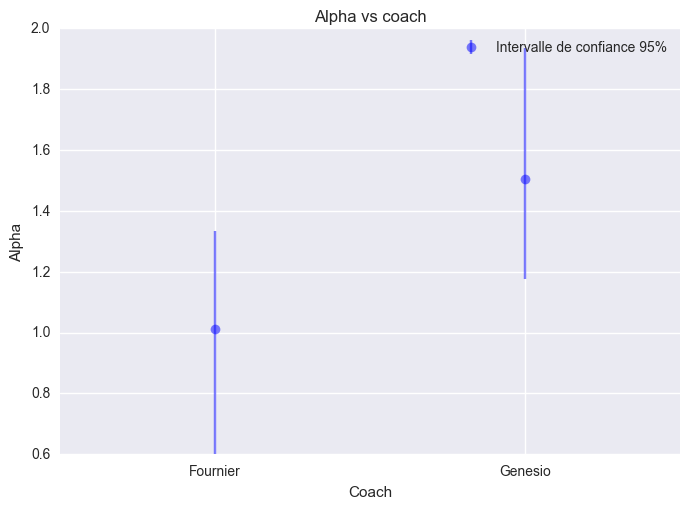

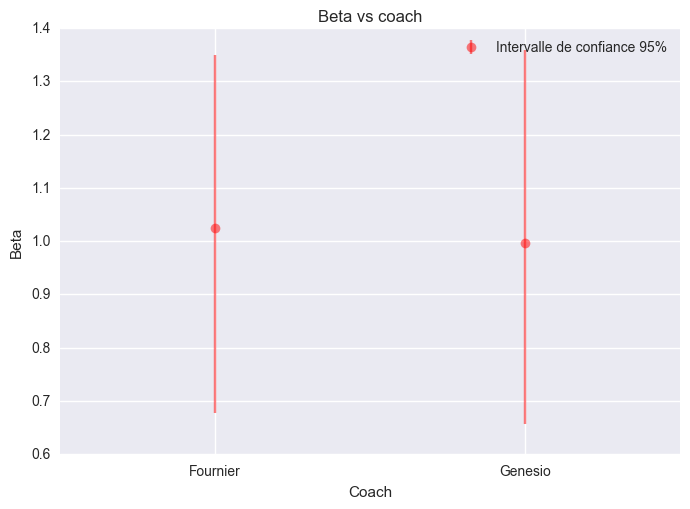

In [92]:
pos=np.arange(len(coaches))

plt.errorbar(pos, alphas_lyon, yerr=interval_alpha, 
             alpha=0.5,color='b',fmt='o', label="Intervalle de confiance 95%")

plt.xticks(pos, coaches)
plt.xlim(-0.5,1.5)
plt.ylabel('Alpha')
plt.xlabel('Coach')
plt.title('Alpha vs coach')
#plt.plot(mcmc[4].s²tats()['atts']['standard deviation'], label='Means 24')

plt.legend()
plt.show()

plt.errorbar(pos, betas_lyon, yerr=interval_beta, 
             alpha=0.5,color='r',fmt='o',label="Intervalle de confiance 95%")
plt.xticks(pos, coaches)
plt.xlim(-0.5,1.5)
plt.ylabel('Beta')
plt.xlabel('Coach')
plt.title('Beta vs coach')
plt.legend()
plt.show()